In [88]:
import duckdb
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [120]:
# Connect to DuckDB
con = duckdb.connect()

# Create simpler dataset with basic features
data = con.execute("""
    WITH sales_data AS (
        SELECT 
            s.date,
            s.store_id,
            s.item_id,
            CAST(s.quantity AS FLOAT) as quantity,
            CAST(s.price_base AS FLOAT) as price,
            -- Add basic date features
            EXTRACT(MONTH FROM s.date) as month,
            EXTRACT(DOW FROM s.date) as day_of_week,
            -- Join with catalog for product info
            c.dept_name,
            c.class_name,
            -- Join with stores for store info
            st.format as store_format,
            st.city
        FROM read_csv_auto('data/sales.csv') s
        LEFT JOIN read_csv_auto('data/catalog.csv') c ON s.item_id = c.item_id
        LEFT JOIN read_csv_auto('data/stores.csv') st ON s.store_id = st.store_id
    )
    SELECT *
    FROM sales_data
""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [119]:
# Connect to DuckDB
con = duckdb.connect()

# Create simpler dataset with basic features
data = con.execute("""
    WITH sales_data AS (
    SELECT 
        s.date,
        s.store_id,
        s.item_id,
        CAST(s.quantity AS FLOAT) as quantity,
        CAST(s.price_base AS FLOAT) as price,
        CAST(CASE WHEN d.doc_id IS NOT NULL THEN 1 ELSE 0 END AS INTEGER) as is_promo,
        CAST(CASE WHEN m.price IS NOT NULL THEN 1 ELSE 0 END AS INTEGER) as is_markdown,
        CAST(COALESCE((d.sale_price_before_promo - d.sale_price_time_promo) / 
            NULLIF(d.sale_price_before_promo, 0) * 100, 0) AS FLOAT) as promo_discount,
        CAST(COALESCE((m.normal_price - m.price) / 
            NULLIF(m.normal_price, 0) * 100, 0) AS FLOAT) as markdown_percentage,
        CAST(COALESCE((ph.price - s.price_base) / 
            NULLIF(s.price_base, 0) * 100, 0) AS FLOAT) as price_change_percentage,
        CAST(ph.code AS INTEGER) as price_change_code,
        EXTRACT(MONTH FROM s.date) as month,
        EXTRACT(DOW FROM s.date) as day_of_week,
        c.dept_name,
        c.class_name,
        st.format as store_format,
        st.city
    FROM read_csv_auto('data/sales.csv') s
    LEFT JOIN read_csv_auto('data/catalog.csv') c ON s.item_id = c.item_id
    LEFT JOIN read_csv_auto('data/stores.csv') st ON s.store_id = st.store_id
    LEFT JOIN read_csv_auto('data/discounts_history.csv') d 
        ON s.item_id = d.item_id 
        AND s.date = d.date
        AND s.store_id = d.store_id
    LEFT JOIN read_csv_auto('data/markdowns.csv') m 
        ON s.item_id = m.item_id 
        AND s.date = m.date
        AND s.store_id = m.store_id
    LEFT JOIN read_csv_auto('data/price_history.csv') ph
        ON s.item_id = ph.item_id
        AND s.date = ph.date 
        AND s.store_id = ph.store_id
    )
    SELECT *
    FROM sales_data
""").fetchdf()

ConversionException: Conversion Error: Type INT64 with value 9999999999 can't be cast because the value is out of range for the destination type INT32
LINE 17:         CAST(ph.code AS INTEGER) as price_change_code,
        EXTRACT(MONTH FROM s.date) as month,
        EXTRACT(DOW FROM s.date) as day_of_week,
        c.dept_name,
        c.class_name,
        st.format as store_format,
        st.city
    FROM read_csv_auto('data/sales.csv') s
    LEFT JOIN read_csv_auto('data/catalog.csv') c ON s.item_id = c.item_id
    LEFT JOIN read_csv_auto('data/stores.csv') st ON s.store_id = st.store_id
    LEFT JOIN read_csv_auto('data/discounts_history.csv') d 
        ON s.item_id = d.item_id 
        AND s.date = d.date
        AND s.store_id = d.store_id
    LEFT JOIN read_csv_auto('data/markdowns.csv') m 
        ON s.item_id = m.item_id 
        AND s.date = m.date
        AND s.store_id = m.store_id
    LEFT JOIN read_csv_auto('data/price_history.csv') ph
        ON s.item_id = ph.item_id
        AND s.date = ph.date 
        AND s.store_id = ph.store_id
    )
    SELECT *
    FROM sales_data
...
                 ^

In [90]:
data.isnull().sum()

date                       0
store_id                   0
item_id                    0
quantity                   0
price                      0
is_promo                   0
is_markdown                0
promo_discount             0
markdown_percentage        0
month                      0
day_of_week                0
dept_name              36585
class_name             36585
store_format               0
city                       0
dtype: int64

In [62]:
data

,date,store_id,item_id,quantity,price,is_promo,is_markdown,promo_discount,markdown_percentage,month,day_of_week,dept_name,class_name,store_format,city
0,2023-08-04,1,f0309b5a974b,1.0,59.900002,1,0,25.031290,0.000000,8,5,НЕСЛАДКИЕ МУЧНЫЕ ИЗДЕЛИЯ,КРЕКЕРЫ,Format-1,City1
1,2023-08-04,1,5f3114373ddd,2.0,449.899994,1,0,18.185125,0.000000,8,5,ВИНО,ВИНА ИГРИСТЫЕ,Format-1,City1
2,2023-08-04,1,56edb7bdecaf,2.0,169.899994,1,0,24.146257,0.000000,8,5,"КЕТЧУПЫ,СОУСЫ НА ТОМАТНОЙ ОСНОВЕ",КЕТЧУПЫ,Format-1,City1
3,2023-08-04,1,034037aebd6e,7.0,99.900002,1,0,0.000000,0.000000,8,5,МАСЛО ПОДСОЛНЕЧНОЕ,НЕРАФИНИРОВАННОЕ,Format-1,City1
4,2023-08-04,1,0780b159bd55,1.0,319.899994,1,0,20.935101,0.000000,8,5,ПЕРСОНАЛЬНЫЙ УХОД,УХОД ЗА ВОЛОСАМИ,Format-1,City1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432948,2024-09-15,4,9f45a49e5ee4,2.0,757.299988,0,1,0.000000,37.010101,9,0,ТОРТЫ,ВОЗДУШНЫЕ,MaxiEuro,City3
7432949,2024-09-15,4,75a435426869,5.0,692.099976,0,1,0.000000,40.000000,9,0,ТОРТЫ,БИСКВИТНЫЕ БЕЛЫЕ,MaxiEuro,City3
7432950,2024-08-20,4,d60184cf6ca5,8.0,149.500000,0,1,0.000000,40.000000,8,2,None,None,MaxiEuro,City3
7432951,2024-08-27,4,d60184cf6ca5,12.0,155.389999,0,1,0.000000,40.000000,8,2,None,None,MaxiEuro,City3


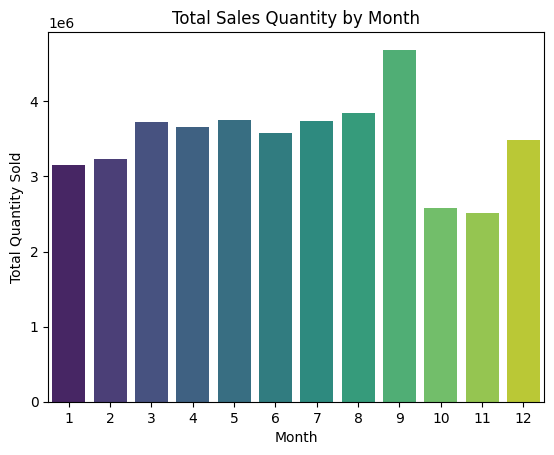

In [63]:
monthly_sales = data.groupby('month')['quantity'].sum().reset_index()

# Plot
sns.barplot(data=monthly_sales, x='month', y='quantity', palette='viridis')
plt.title('Total Sales Quantity by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.show()

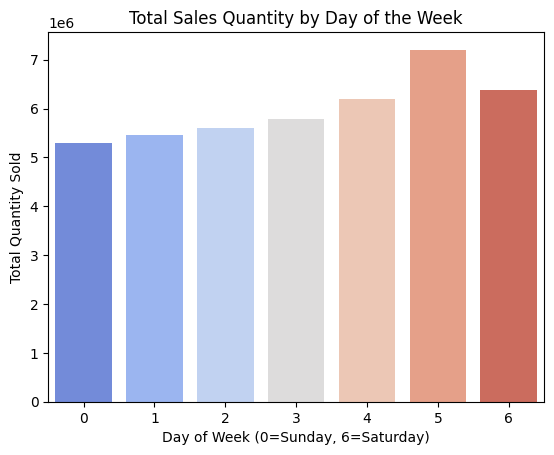

In [64]:
# Group by day_of_week to calculate total sales quantity
day_sales = data.groupby('day_of_week')['quantity'].sum().reset_index()

# Plot
sns.barplot(data=day_sales, x='day_of_week', y='quantity', palette='coolwarm')
plt.title('Total Sales Quantity by Day of the Week')
plt.xlabel('Day of Week (0=Sunday, 6=Saturday)')
plt.ylabel('Total Quantity Sold')
plt.show()

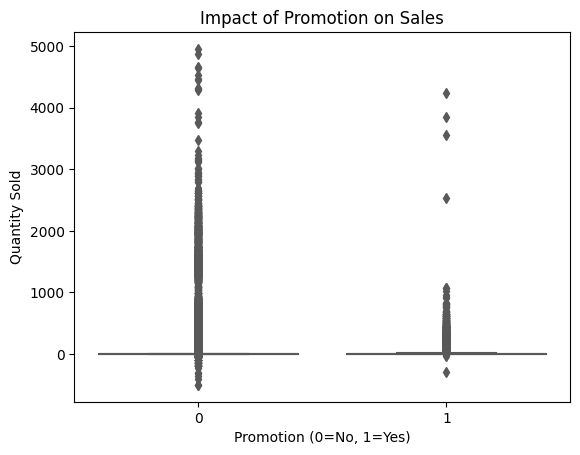

In [65]:
# Boxplot to compare quantity for promotional and non-promotional items
sns.boxplot(data=data, x='is_promo', y='quantity', palette='Set2')
plt.title('Impact of Promotion on Sales')
plt.xlabel('Promotion (0=No, 1=Yes)')
plt.ylabel('Quantity Sold')
plt.show()

In [66]:
promo_stats = data.groupby('is_promo')['quantity'].describe()
print(promo_stats)

              count      mean        std    min  25%  50%    75%     max
is_promo                                                                
0         5913987.0  5.563571  29.642599 -500.0  1.0  2.0  4.000  4952.0
1         1518966.0  5.949267  15.928087 -292.0  1.0  2.0  5.005  4243.0


In [91]:
# Remove negative prices
data = data[data['price'] > 0]

In [68]:
# Remove extreme outliers
#Q1 = data['price'].quantile(0.25)
#Q3 = data['price'].quantile(0.75)
#IQR = Q3 - Q1
#data = data[(data['price'] >= Q1 - 1.5*IQR) & (data['price'] <= Q3 + 1.5*IQR)]

In [92]:
data['price'] = np.log1p(data['price'])

In [93]:
model = Ridge(alpha=1.0)

In [94]:
data.price.min()

0.0099503305

In [107]:
# Add lag features
#data['quantity_lag1'] = data.groupby(['store_id', 'item_id'])['quantity'].shift(1)
#data['quantity_lag7'] = data.groupby(['store_id', 'item_id'])['quantity'].shift(7)

# Add rolling means
#data['rolling_mean_7d'] = data.groupby(['store_id', 'item_id'])['quantity'].transform(
#    lambda x: x.rolling(7, min_periods=1).mean()
#)

# Add price changes
#data['price_change'] = data.groupby(['store_id', 'item_id'])['price'].pct_change()

# Add seasonal features
data['is_weekend'] = (data['day_of_week'].isin([5,6])).astype(int)
data['is_month_end'] = (pd.to_datetime(data['date']).dt.is_month_end).astype(int)
data['promo_price_ratio'] = data['price'] / data.groupby(['item_id'])['price'].transform('mean')


# Add interaction terms
#data['price_promo_interaction'] = data['price'] * data['is_promo']

In [108]:
data

,date,store_id,item_id,quantity,price,is_promo,is_markdown,promo_discount,markdown_percentage,month,day_of_week,dept_name,class_name,store_format,city,is_weekend,is_month_end,promo_price_ratio
0,2023-08-04,0,26455,1.0,4.109233,1,0,25.031290,0.000000,8,5,90,194,0,0,1,0,0.961944
1,2023-08-04,0,10502,2.0,6.111246,1,0,18.185125,0.000000,8,5,14,42,0,0,1,0,0.977521
2,2023-08-04,0,9603,2.0,5.141078,1,0,24.146257,0.000000,8,5,48,145,0,0,1,0,0.956277
3,2023-08-04,0,349,7.0,4.614130,1,0,0.000000,0.000000,8,5,77,281,0,0,1,0,0.978287
4,2023-08-04,0,821,1.0,5.771130,1,0,20.935101,0.000000,8,5,98,482,0,0,1,0,0.990581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432948,2024-09-15,3,17685,2.0,6.631079,0,1,0.000000,37.010101,9,0,161,48,3,2,0,0,0.983710
7432949,2024-09-15,3,13041,5.0,6.541174,0,1,0.000000,40.000000,9,0,161,20,3,2,0,0,1.008219
7432950,2024-08-20,3,23531,8.0,5.013963,0,1,0.000000,40.000000,8,2,0,1,3,2,0,0,0.968375
7432951,2024-08-27,3,23531,12.0,5.052353,0,1,0.000000,40.000000,8,2,0,1,3,2,0,0,0.975789


In [97]:
# Prepare features
def prepare_features(df):
    # Encode categorical variables
    cat_columns = ['dept_name', 'class_name', 'store_format', 'city','item_id','store_id','is_promo','is_markdown']
    label_encoders = {}
    
    for col in cat_columns:
        df[col] = df[col].fillna('Unknown')  # Handle missing values
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    
    # Fill missing numerical values
    df = df.fillna(0)
    
    return df, label_encoders

In [98]:
data['date'].max()

Timestamp('2024-09-26 00:00:00')

In [100]:
# Prepare the data
data, label_encoders = prepare_features(data)

# Split features and target
target = 'quantity'
features = ['price', 'month', 'day_of_week', 'dept_name', 'class_name', 
            'store_format', 'city', 'store_id', 'item_id','is_promo','is_markdown',
            'is_weekend','is_month_end']

X = data[features]
y = data[target]

# Split train/test based on date
split_date = '2024-06-01'  # adjust based on your data
train_mask = pd.to_datetime(data['date']) < split_date
X_train = X[train_mask]
X_test = X[~train_mask]
y_train = y[train_mask]
y_test = y[~train_mask]


# Train model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=14,
    random_state=42,
    #enable_categorical=True
)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
model_GBR = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_GBR.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [102]:
data.price.min()

0.0099503305

In [112]:
# Evaluate
y_pred = model.predict(X_test)
print("\nModel Evaluation Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")


Model Evaluation Metrics:
RMSE: 19.80
MAE: 3.26
R2 Score: 0.60


In [104]:
X_train.shape

(5819285, 13)

In [105]:
X_test.shape

(1605575, 13)

* Feature importance show that rolling_mean_7d is the most important feature

In [106]:
# Show feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
print("\nFeature Importance:")
print(importance.sort_values('importance', ascending=False))


Feature Importance:
         feature  importance
5   store_format    0.388666
4     class_name    0.198343
8        item_id    0.193146
3      dept_name    0.092250
0          price    0.050775
9       is_promo    0.039977
2    day_of_week    0.014296
12  is_month_end    0.009358
10   is_markdown    0.006665
1          month    0.006523
6           city    0.000000
7       store_id    0.000000
11    is_weekend    0.000000


In [83]:
data.dtypes

date                   datetime64[us]
store_id                        int64
item_id                         int64
quantity                      float32
price                         float32
is_promo                        int64
is_markdown                     int64
promo_discount                float32
markdown_percentage           float32
month                           int64
day_of_week                     int64
dept_name                       int64
class_name                      int64
store_format                    int64
city                            int64
quantity_lag1                 float32
quantity_lag7                 float32
rolling_mean_7d               float64
dtype: object